In [1]:
import pandas as pd
from pytorch_lightning.callbacks import EarlyStopping, Callback, ModelCheckpoint
from ray import tune
from ray.tune import CLIReporter
from ray import tune
from ray import train
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from ray.tune.schedulers import ASHAScheduler
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError, MetricCollection
from darts.dataprocessing.transformers import Scaler
from darts.models import NLinearModel
from darts import TimeSeries, concatenate
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import tensorboard
import os

In [2]:
class LossLoggingCallback(Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []  # To store validation losses
        self.train_losses = []  # To store training losses

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics["val_loss"].item()
        self.val_losses.append(val_loss)
        print(f"Epoch {trainer.current_epoch}: val_loss={val_loss}")
        train.report({"loss": val_loss})

    def on_train_epoch_end(self, trainer, pl_module, unused=None):  # unused parameter for compatibility
        # Assuming you have a metric named "train_loss" logged
        if "train_loss" in trainer.callback_metrics:
            train_loss = trainer.callback_metrics["train_loss"].item()
            self.train_losses.append(train_loss)
            print(f"Epoch {trainer.current_epoch}: train_loss={train_loss}")

In [7]:
df = pd.read_csv('EDvisitfile.csv')

# 确保'date'列是DateTime类型
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# 分割数据集为训练集、验证集和测试集（假设您已经根据时间排序）
#train_proportion = 0.5
#val_proportion = 0.3

# Calculate the split indices
total_length = len(df)
train_end = 3646
#val_end = 4011
#val_end = train_end + int(total_length * val_proportion)

# Split the DataFrame
train_df = df.iloc[:train_end]
test_df = df.iloc[train_end:]
#test_df = df.iloc[val_end:]
#val_df = df.iloc[train_end:val_end]
#test_df = df.iloc[val_end:]

# 步骤2: 使用MinMaxScaler缩放数据
# 定义并拟合scaler
scaler = MinMaxScaler()
scaler.fit(train_df[['No']])  # 只用训练数据拟合scaler

# 缩放训练集和验证集
train_df.loc[:, 'No_scaled'] = scaler.transform(train_df[['No']])
#val_df.loc[:, 'No_scaled'] = scaler.transform(val_df[['No']])
test_df.loc[:, 'No_scaled'] = scaler.transform(test_df[['No']])  # 用相同的scaler转换测试集以避免数据泄露

train_series = TimeSeries.from_dataframe(train_df, value_cols='No_scaled' )
#val_series = TimeSeries.from_dataframe(val_df, value_cols='No_scaled' )
test_series = TimeSeries.from_dataframe(test_df, value_cols='No_scaled' )

# 原始数据转换为TimeSeries对象，如果需要
train_series_origin = TimeSeries.from_dataframe(train_df, value_cols='No'  )
#val_series_origin = TimeSeries.from_dataframe(val_df, value_cols='No' )
test_series_origin = TimeSeries.from_dataframe(test_df, value_cols='No' )

# 选择需要的列创建多变量时间序列(都是one hot coding)
columns = ['Dayoff', 'Mon', 'Tue', 'Wed', 'Thr', 'Fri', 'Sat', 'Sun',  'YearScaled', 'MonthScaled', 'Dayscaled', 'NewYear', '3Lock']
df_multivariate = df[columns]

# 将DataFrame转换为多变量时间序列
ED_covariates = TimeSeries.from_dataframe(df_multivariate )

C:\Users\ian11\AppData\Local\Temp\ipykernel_21280\4068363101.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.loc[:, 'No_scaled'] = scaler.transform(train_df[['No']])
C:\Users\ian11\AppData\Local\Temp\ipykernel_21280\4068363101.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:, 'No_scaled'] = scaler.transform(test_df[['No']])  # 用相同的scaler转换测试集以避免数据泄露


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
C:\Users\ian11\anaconda3\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:615: UserWarning: Checkpoint directory C:\darts_logs\_model.pth.tar exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 3.2 K 
---------------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

C:\Users\ian11\anaconda3\Lib\site-packages\torch\__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\b\abs_2112s1s0to\croot\pytorch-select_1700158736573\work\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


Epoch 0: val_loss=0.0067119477694452066


C:\Users\ian11\anaconda3\Lib\site-packages\ray\train\_internal\session.py:638: UserWarning: `report` is meant to only be called inside a function that is executed by a Tuner or Trainer. Returning `None`.
  warnings.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: val_loss=0.006266069000158158
Epoch 0: train_loss=0.0056391074564300135


Validation: 0it [00:00, ?it/s]

Epoch 1: val_loss=0.005964980105533973
Epoch 1: train_loss=0.0062646352232515


Validation: 0it [00:00, ?it/s]

Epoch 2: val_loss=0.005773136305712038
Epoch 2: train_loss=0.004692665309977441


Validation: 0it [00:00, ?it/s]

Epoch 3: val_loss=0.00570003662255778
Epoch 3: train_loss=0.0070227998051666735


Validation: 0it [00:00, ?it/s]

Epoch 4: val_loss=0.005629242619344658
Epoch 4: train_loss=0.005285670118209298


Validation: 0it [00:00, ?it/s]

Epoch 5: val_loss=0.005585402237732527
Epoch 5: train_loss=0.009336330716992735


Validation: 0it [00:00, ?it/s]

Epoch 6: val_loss=0.0055202143964857365
Epoch 6: train_loss=0.006795200286658485


Validation: 0it [00:00, ?it/s]

Epoch 7: val_loss=0.005433599176250843
Epoch 7: train_loss=0.008268454240487028


Validation: 0it [00:00, ?it/s]

Epoch 8: val_loss=0.005456026798593386
Epoch 8: train_loss=0.007604009779066773


Validation: 0it [00:00, ?it/s]

Epoch 9: val_loss=0.005367720653005784
Epoch 9: train_loss=0.005507021032994694


Validation: 0it [00:00, ?it/s]

Epoch 10: val_loss=0.005439691010714671
Epoch 10: train_loss=0.00459267527501684


Validation: 0it [00:00, ?it/s]

Epoch 11: val_loss=0.005404732180486787
Epoch 11: train_loss=0.003054788572712404


Validation: 0it [00:00, ?it/s]

Epoch 12: val_loss=0.0052729772209689045
Epoch 12: train_loss=0.004640977634062865


Validation: 0it [00:00, ?it/s]

Epoch 13: val_loss=0.005362278156510794
Epoch 13: train_loss=0.007634034805027683


Validation: 0it [00:00, ?it/s]

Epoch 14: val_loss=0.0053866380541227705
Epoch 14: train_loss=0.003030442770049764


Validation: 0it [00:00, ?it/s]

Epoch 15: val_loss=0.005253989490343368
Epoch 15: train_loss=0.004422125693501521


Validation: 0it [00:00, ?it/s]

Epoch 16: val_loss=0.005211824373437027
Epoch 16: train_loss=0.006174236647407809


Validation: 0it [00:00, ?it/s]

Epoch 17: val_loss=0.0052629042029064405
Epoch 17: train_loss=0.00711361446012755


Validation: 0it [00:00, ?it/s]

Epoch 18: val_loss=0.00532908257669639
Epoch 18: train_loss=0.00306269493869461


Validation: 0it [00:00, ?it/s]

Epoch 19: val_loss=0.005442830107749395
Epoch 19: train_loss=0.011564922128735885


Validation: 0it [00:00, ?it/s]

Epoch 20: val_loss=0.005306768271014228
Epoch 20: train_loss=0.002970240570981051


Validation: 0it [00:00, ?it/s]

Epoch 21: val_loss=0.005340027422363926
Epoch 21: train_loss=0.004638234026497728


Validation: 0it [00:00, ?it/s]

Epoch 22: val_loss=0.005300309334291258
Epoch 22: train_loss=0.00535935908767245


Validation: 0it [00:00, ?it/s]

Epoch 23: val_loss=0.005372120860647724
Epoch 23: train_loss=0.003136606233447616


Validation: 0it [00:00, ?it/s]

Epoch 24: val_loss=0.005247973542379667
Epoch 24: train_loss=0.004559411624146274


Validation: 0it [00:00, ?it/s]

Epoch 25: val_loss=0.005266139247672012
Epoch 25: train_loss=0.006020443894849707


Validation: 0it [00:00, ?it/s]

Epoch 26: val_loss=0.005226583666776087
Epoch 26: train_loss=0.006304058570627111


Validation: 0it [00:00, ?it/s]

Epoch 27: val_loss=0.005239017644149113
Epoch 27: train_loss=0.012116551505077419


Validation: 0it [00:00, ?it/s]

Epoch 28: val_loss=0.0052179731675404475
Epoch 28: train_loss=0.004122320321301023


Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 29: val_loss=0.005257443532011832
Epoch 29: train_loss=0.006432814699996996


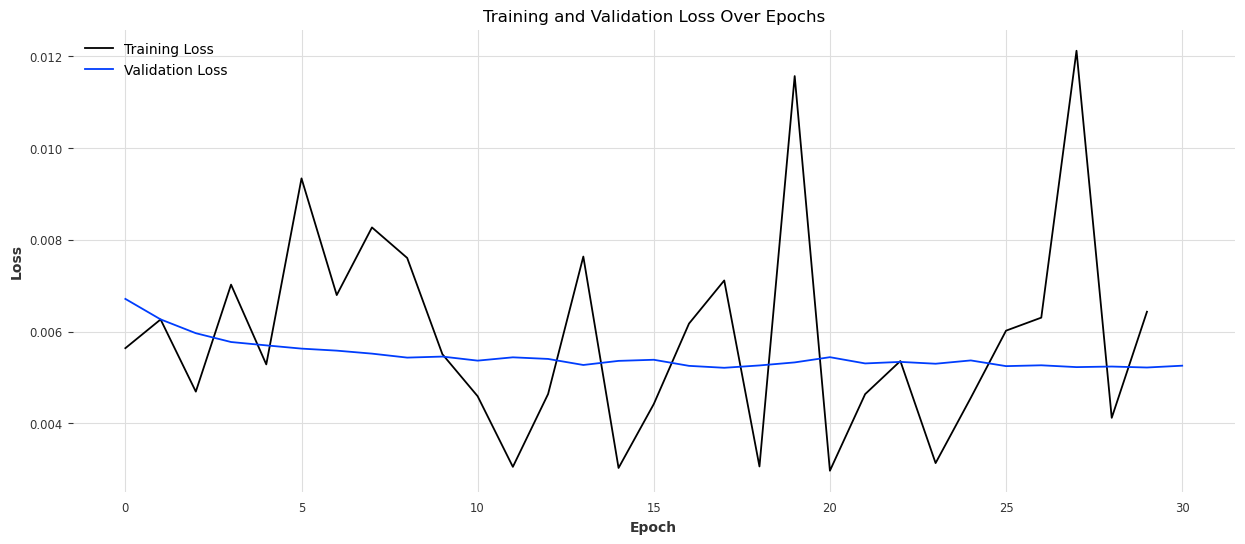

In [8]:
loss_logging_callback = LossLoggingCallback()

checkpoint_callback = ModelCheckpoint(
    filename='_model_{epoch:02d}',
    monitor='val_loss',
    save_top_k=-1,
    every_n_epochs=5,
    dirpath='/darts_logs/_model.pth.tar'# Save every 5 epochs
)

torch_metrics = MetricCollection([MeanAbsolutePercentageError(), MeanAbsoluteError()])

model = NLinearModel(
    input_chunk_length=15,
    output_chunk_length=15,
    batch_size=64,
    model_name="NLinearFine2019(700)",
    lr_scheduler_kwargs=0.00005,
    save_checkpoints=True,
    pl_trainer_kwargs = {
    "callbacks": [loss_logging_callback, checkpoint_callback]},)

# After defining the model, proceed with the training as before
models = {
    "NLinear": model,
}

model.fit(
    epochs=30,
    series=[train_series],
    past_covariates=[ED_covariates],
    val_series=[train_series],
    val_past_covariates=[ED_covariates]
    #past_covariates=[WeekdayTrain, DayoffTrain]
    #enable_checkpointing=True,
)

# Step 3: Plotting the losses after training is completed
plt.figure(figsize=(15, 6))

# Plot training losses
plt.plot(loss_logging_callback.train_losses, label="Training Loss")

# Plot validation losses
plt.plot(loss_logging_callback.val_losses, label="Validation Loss")

plt.title("Training and Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [9]:
from darts.metrics import mae, mse, mape
import matplotlib.pyplot as plt

In [10]:
model = NLinearModel.load_from_checkpoint('NLinearFine2019(700)')
hyperparameters = model.model_params
print(hyperparameters)
#model_loaded = model.load_weights('darts_logs/NHiTSFine2019(50)/checkpoints/last-epoch=49', load_encoders=False, skip_checks=True)
#model_loaded = model.load_weights('darts_logs\NHiTSFine2019(30)\checkpoints', load_encoders=False, skip_checks=True)
Model_prediction = model.predict(731, series=train_series, past_covariates=ED_covariates
                                )
# invert scale, 資料格式轉換
Model_prediction_df = Model_prediction.pd_dataframe()
Model_prediction_df_inverse = scaler.inverse_transform(Model_prediction_df)
Model_prediction_df_inverse = pd.DataFrame(Model_prediction_df_inverse,
                      index=Model_prediction_df.index,
                      columns=Model_prediction_df.columns)

# 計算誤差
Model_prediction_ts_inverse = TimeSeries.from_dataframe(Model_prediction_df_inverse)
Model_mae = mae(test_series_origin, Model_prediction_ts_inverse)
Model_mse = mse(test_series_origin, Model_prediction_ts_inverse)
Model_mape = mape(test_series_origin, Model_prediction_ts_inverse)

print(Model_mae, Model_mse, Model_mape)

`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


OrderedDict([('shared_weights', False), ('const_init', True), ('normalize', False), ('use_static_covariates', True), ('input_chunk_length', 15), ('output_chunk_length', 15), ('batch_size', 64), ('model_name', 'NLinearFine2019(700)'), ('lr_scheduler_kwargs', 5e-05), ('save_checkpoints', True), ('pl_trainer_kwargs', {'callbacks': [<__main__.LossLoggingCallback object at 0x0000019F3B752C90>, <pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x0000019F3B7BED10>]})])


Predicting: 0it [00:00, ?it/s]

47.3179158213944 4108.512031074406 10.170099801197335


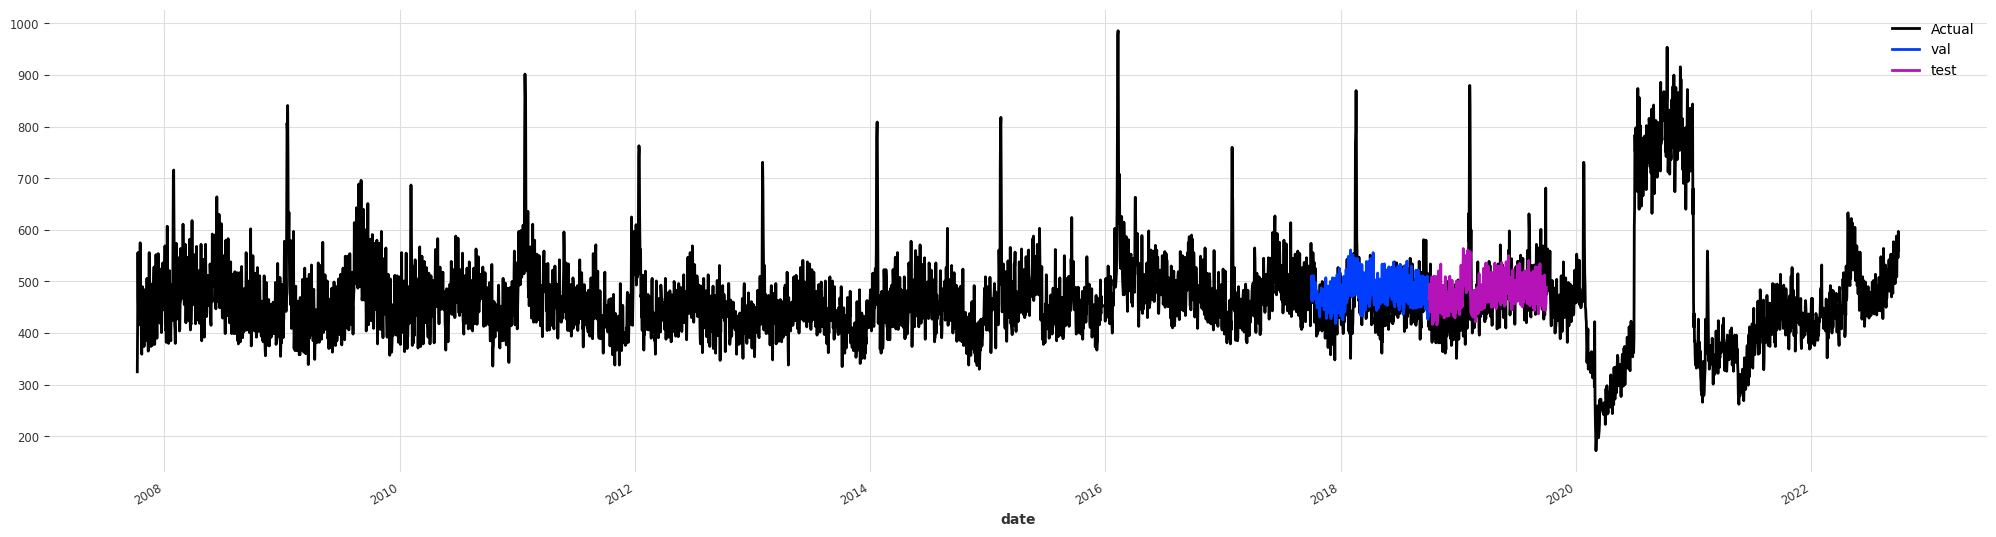

In [11]:
series_origin_complete = TimeSeries.from_dataframe(df, value_cols=['No'])

Model_prediction_ts_inverse_val, Model_prediction_ts_inverse_test = Model_prediction_ts_inverse.split_before(0.5)

# 绘制图表
plt.figure(figsize=(25, 6))
series_origin_complete.plot(label='Actual')

# 使用之前转换和逆缩放后的预测结果
Model_prediction_ts_inverse_val.plot(label='val')
Model_prediction_ts_inverse_test.plot(label='test')

plt.legend()
plt.show()